In [7]:
# This notebook calculates the relationship between temperature and UHI during summertime

# import libraries
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.stats
import matplotlib
import cartopy.crs as ccrs

In [8]:
results_filename = 'US_results_cleaned_data.csv'
results_filepath = 'plots/version1/'

In [4]:
# functions

# plotting 
# define functions used for plotting 
def hw_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

# statistics
def pearsonr_autocorrelated(x, y):
    """
    Calculates a Pearson correlation coefficient and the p-value for testing
    non-correlation.
    The Pearson correlation coefficient measures the linear relationship
    between two datasets. Strictly speaking, Pearson's correlation requires
    that each dataset be normally distributed. Like other correlation
    coefficients, this one varies between -1 and +1 with 0 implying no
    correlation. Correlations of -1 or +1 imply an exact linear
    relationship. Positive correlations imply that as x increases, so does
    y. Negative correlations imply that as x increases, y decreases.
    The p-value roughly indicates the probability of an uncorrelated system
    producing datasets that have a Pearson correlation at least as extreme
    as the one computed from these datasets. The p-values are not entirely
    reliable but are probably reasonable for datasets larger than 500 or so.
    Parameters
    ----------
    x : (N,) array_like
        Input
    y : (N,) array_like
        Input
    Returns
    -------
    (Pearson's correlation coefficient,
     2-tailed p-value)
    References
    ----------
    http://www.statsoft.com/textbook/glosp.html#Pearson%20Correlation
    """
    # x and y should have same length.
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    r = np.corrcoef(y[1:],y[0:-1])[0,1] #y.autocorr(1)
    n_prime = n*(1-r)/(1+r)
    mx = x.mean()
    my = y.mean()
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym)
    r_den = np.sqrt(ss(xm) * ss(ym))
    r = r_num / r_den

    # Presumably, if abs(r) > 1, then it is only some small artifact of floating
    # point arithmetic.
    r = max(min(r, 1.0), -1.0)
    df = n_prime-2
    if abs(r) == 1.0:
        prob = 0.0
    else:
        t_squared = r*r * (df / ((1.0 - r) * (1.0 + r)))
        prob = betai(0.5*df, 0.5, df / (df + t_squared))
    return r, prob

def ss(a, axis=0):
    """
    Squares each element of the input array, and returns the sum(s) of that.
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int or None, optional
        The axis along which to calculate. If None, use whole array.
        Default is 0, i.e. along the first axis.
    Returns
    -------
    ss : ndarray
        The sum along the given axis for (a**2).
    See also
    --------
    square_of_sums : The square(s) of the sum(s) (the opposite of `ss`).
    Examples
    --------
    >>> from scipy import stats
    >>> a = np.array([1., 2., 5.])
    >>> stats.ss(a)
    30.0
    And calculating along an axis:
    >>> b = np.array([[1., 2., 5.], [2., 5., 6.]])
    >>> stats.ss(b, axis=1)
    array([ 30., 65.])
    """
    a, axis = _chk_asarray(a, axis)
    return np.sum(a*a, axis)

def _chk_asarray(a, axis):
    if axis is None:
        a = np.ravel(a)
        outaxis = 0
    else:
        a = np.asarray(a)
        outaxis = axis
    return a, outaxis

def betai(a, b, x):
    """
    Returns the incomplete beta function.
    I_x(a,b) = 1/B(a,b)*(Integral(0,x) of t^(a-1)(1-t)^(b-1) dt)
    where a,b>0 and B(a,b) = G(a)*G(b)/(G(a+b)) where G(a) is the gamma
    function of a.
    The standard broadcasting rules apply to a, b, and x.
    Parameters
    ----------
    a : array_like or float > 0
    b : array_like or float > 0
    x : array_like or float
        x will be clipped to be no greater than 1.0 .
    Returns
    -------
    betai : ndarray
        Incomplete beta function.
    """
    x = np.asarray(x)
    x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
    return scipy.special.betainc(a, b, x)


In [5]:
# Calculate the relationship between summertime  UHI and t_min, save it out for every city
pairs = pd.read_csv('USghcnpairs_stationlengths.csv')
paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]

# pre-allocate
slopes           = np.ones(paired_df.shape[0])*np.nan
residuals        = np.ones(paired_df.shape[0])*np.nan
correlations     = np.ones(paired_df.shape[0])*np.nan
urban_start_date = np.ones(paired_df.shape[0])*np.nan
urban_end_date   = np.ones(paired_df.shape[0])*np.nan
rural_start_date = np.ones(paired_df.shape[0])*np.nan
rural_end_date   = np.ones(paired_df.shape[0])*np.nan
n_events         = np.ones(paired_df.shape[0])*np.nan
mean_rural_temp  = np.ones(paired_df.shape[0])*np.nan
mean_UHI         = np.ones(paired_df.shape[0])*np.nan
p_value          = np.ones(paired_df.shape[0])*np.nan
intercepts       = np.ones(paired_df.shape[0])*np.nan
max_UHI_day      = np.ones(paired_df.shape[0])*np.nan

In [14]:

for i in range(59, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['1985-01-01':].index, ruraldata['TMIN']['1985-01-01':].index).shape[0] > 300): 
    #if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) : 

        # Find the date at which they both start
        startdate = max(min(ruraldata['TMIN'].index), min(urbandata['TMIN'].index))

        # Calculate minimum daily thresholds starting from 1985
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 
        
        rural_start_date[i] = rural_tmin[~np.isnan(rural_tmin)].index[0].year
        rural_end_date[i]   = rural_tmin[~np.isnan(rural_tmin)].index[-1].year
        urban_start_date[i] = urban_tmin[~np.isnan(urban_tmin)].index[0].year
        urban_end_date[i]   = urban_tmin[~np.isnan(urban_tmin)].index[-1].year
        
        # extract summertime data 
        rural_summer = rural_tmin[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)]
        urban_summer = urban_tmin[np.logical_or(urban_tmin.index.month==6, urban_tmin.index.month==7, urban_tmin.index.month==8)]
        
        # clean data: eliminate min temperatures below 4 or above 35
        rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
        urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]
        
        #calculate UHI
        UHI = urban_summer - rural_summer

        # Save out the mean temperature and UHI
        mean_UHI[i] = UHI.mean()
        max_UHI_day[i] = UHI.groupby(UHI.index.day_of_year).mean().argmax() # average yearly UHI cycle, and see which day has max UHI
        mean_rural_temp[i] = rural_summer.mean()
        
        x = rural_summer
        y = UHI
        
        ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
        # plot
        plt.figure()
        handle = hw_scatter(x[ind],y[ind],'%s JJA Temp vs UHI'%city, 'Rural Temp', 'UHI')
        plt.savefig(results_filepath+ 'hwUHI%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
        plt.close()
        try: 
            slope, intercept, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
            #V = np.polyfit(x[ind],y[ind],1, full = True)
            #C = pearsonr_autocorrelated(x[ind], y[ind])
            slopes[i] = slope #V[0][0]

            intercepts[i] = intercept
            residuals[i] = std_err#V[1][0]
            correlations[i] = r_value#C[0]#np.corrcoef(x[ind],y[ind])[0,1]
            p_value[i] = p#C[1]
            n_events[i] = ind.values.sum()

        except TypeError : 
            print 'TypeError'

    
    if np.mod(i,10) == 0 : 
        
        results_df = pd.DataFrame()
        results_df['City']  = paired_df['City']
        results_df['Slope'] = slopes
        results_df['Intercepts'] = intercepts
        results_df['Residual'] = residuals
        results_df['Correlation'] = correlations
        results_df['P-value'] = p_value
        results_df['Urban start date'] = urban_start_date
        results_df['Urban end date'] = urban_end_date
        results_df['Rural start date'] = rural_start_date
        results_df['Rural end date'] = rural_end_date
        results_df['Data points'] = n_events
        results_df['Mean UHI'] = mean_UHI
        results_df['Day of Max UHI'] = max_UHI_day
        results_df['Mean JJA Rural Temp'] = mean_rural_temp

        results_df.to_csv(results_filename)
        
results_df = pd.DataFrame()
results_df['City']  = paired_df['City']
results_df['Slope'] = slopes
results_df['Intercepts'] = intercepts
results_df['Residual'] = residuals
results_df['Correlation'] = correlations
results_df['P-value'] = p_value
results_df['Urban start date'] = urban_start_date
results_df['Urban end date'] = urban_end_date
results_df['Rural start date'] = rural_start_date
results_df['Rural end date'] = rural_end_date
results_df['Data points'] = n_events
results_df['Mean UHI'] = mean_UHI
results_df['Day of Max UHI'] = max_UHI_day
results_df['Mean JJA Rural Temp'] = mean_rural_temp
results_df.to_csv(results_filename)

Detroit
San Francisco
Denver
Houston
Miami
Atlanta
Chicago
Los Angeles
Washington, D.C.
New York


In [9]:
i

58

In [13]:
ind.sum()

0

In [15]:
results_df = results_df[results_df['Data points']>0]

//anaconda/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


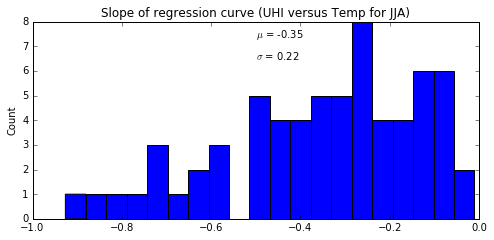

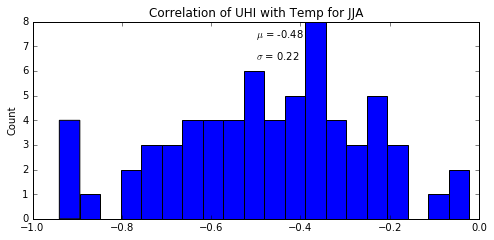

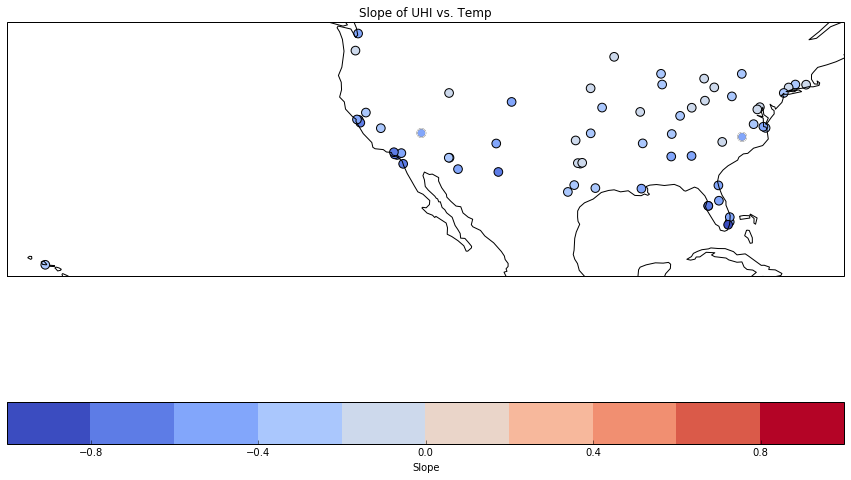

In [16]:
# plot slope histograme
data = results_df['Slope'] #slopes
data = data[~np.isnan(data)]
plt.figure(figsize=[8,12])
plt.subplot(3,1,1)
plt.hist(data, 20)
plt.title('Slope of regression curve (UHI versus Temp for JJA)')
#plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
plt.ylabel('Count')
plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.savefig(results_filepath+'JJAslopehistogram.png')

# plot correlation histogram
data = results_df['Correlation']#correlations
data = data[~np.isnan(data)]
plt.figure(figsize=[8,12])
plt.subplot(3,1,2)
plt.hist(data, 20)
plt.title('Correlation of UHI with Temp for JJA')
#plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
plt.ylabel('Count')
plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.savefig(results_filepath+ 'JJAcorrelationhistogram.png')

# make a map of the slopes
fig = plt.figure(figsize=[15,15])
# Define colors 
cmap = matplotlib.cm.coolwarm
c = results_df['Slope'].values
# Define lat/lon 
x = paired_df['Urban Lon'].loc[results_df[results_df['Data points']>0].index]
y = paired_df['Urban Lat'].loc[results_df[results_df['Data points']>0].index]
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 75
# Define the cartopy basemaps
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ind = np.isnan(c)
plotHandle = ax.scatter(x,y,
                        c = c, s = marker_size, transform=ccrs.Geodetic(),
                 cmap = cmap,
                 norm = norm)
# mask insignificantly correlated cities with a white circle
insig_inds = np.where(results_df['P-value']>0.05)
if len(insig_inds[0]) > 0: 
    ax.scatter(paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
            c = 'none', s = marker_size, transform=ccrs.Geodetic(), edgecolors='white',)

cbar1 = plt.colorbar(plotHandle, label = 'Slope', orientation='horizontal')
plt.title('Slope of UHI vs. Temp')
plt.savefig(results_filepath+ 'JJAslopemap.png')

In [18]:
plt.scatter(results_df['Mean UHI'].drop(205), results_df['Slope'].drop(205))
plt.xlabel('Mean UHI (JJA)')
plt.ylabel('Temp. vs UHI Slope')
plt.title('Do cities with larger UHIs have larger slopes?')
r = np.corrcoef(results_df['Mean UHI'].drop(205), results_df['Slope'].drop(205))[0,1]
plt.annotate('r = %2.2f'%r, xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# omitted SLC as an outlier. 

ValueError: labels [205] not contained in axis

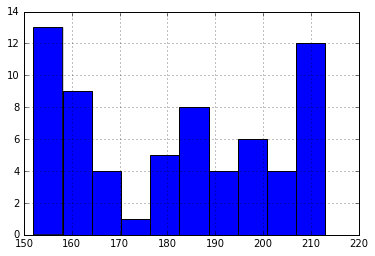

In [19]:
results_df['Day of Max UHI'].hist()

In [20]:
# make a plot of yearly averaged UHI for cities
#results_filepath = 'plots/seasonalUHIcycles/'
results_filepath = 'plots/version1/UHIcycle/'
import matplotlib.dates as dates
time = np.arange('2008-01-01', '2008-12-31', dtype='datetime64[D]')

for i in range(0, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['1985-01-01':].index, ruraldata['TMIN']['1985-01-01':].index).shape[0] > 300): 

        for temp in ['TMIN','TMAX'] : 
            rural = pd.to_numeric(ruraldata[temp]['1985-01-01':].value/10.)
            urban = pd.to_numeric(urbandata[temp]['1985-01-01':].value/10.)

            UHI = urban- rural 

            # plot 
            fig1 = plt.figure()
            ax = fig1.add_subplot(1,1,1)
            ax.plot(time,
                    UHI.groupby(UHI.index.day_of_year).mean().rolling(window=21).mean()[0:365], color = 'k')
            ax.fill_between(time, 
                             UHI.groupby(UHI.index.day_of_year).mean().rolling(window=21).mean()[0:-1]- UHI.groupby(UHI.index.day_of_year).std().rolling(window=21).mean()[0:-1], 
                             UHI.groupby(UHI.index.day_of_year).mean().rolling(window=21).mean()[0:-1] + UHI.groupby(UHI.index.day_of_year).std().rolling(window=21).mean()[0:-1], color = 'lightgray')

            ax.yaxis.tick_left()
            ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
            plt.xlabel('Month')
            plt.ylabel('UHI')
            plt.title('Climatological UHI %s %s'%(temp,city))

            ax2 = fig1.add_subplot(111, sharex=ax, frameon=False)
            line2 = ax2.plot(time, rural.groupby(rural.index.day_of_year).mean().rolling(window=21).mean()[0:365], '-.', color = 'k')
            ax2.yaxis.tick_right()
            ax2.yaxis.set_label_position("right")
            plt.ylabel('Mean Rural %s'%temp)

            filename = results_filepath+city.replace(" ", "")[0:5]+temp+'.png'
            plt.savefig(filename)
    plt.close('all')

Mesa
Arlington
Irvine
New Haven
Fort Lauderdale
Long Beach
Hartford
Providence
Birmingham
St. Petersburg
Virginia Beach
Oakland
West Palm Beach
Louisville
Charlotte
Columbus
San Bernardino
Bridgeport
St. Paul
Tucson
Fresno
Albuquerque
Kansas City
Tulsa
Ft. Worth
Austin
El Paso
Orlando
Jacksonville
Indianapolis
Richmond
Baltimore
San Jose
Sacramento
Las Vegas
Portland
Salt Lake City
Omaha
Oklahoma City
San Antonio
Raleigh
Cleveland
Cincinnati
Nashville
Memphis
Norfolk
Milwaukee
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Tampa
Philadelphia
Detroit
San Francisco
Denver
Houston
Miami
Atlanta
Chicago
Los Angeles
Washington, D.C.
New York


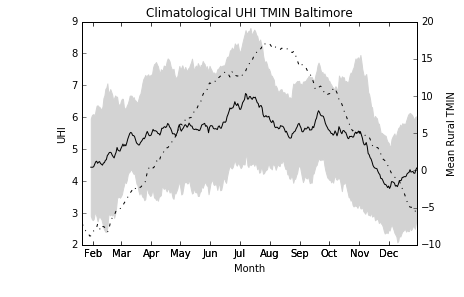

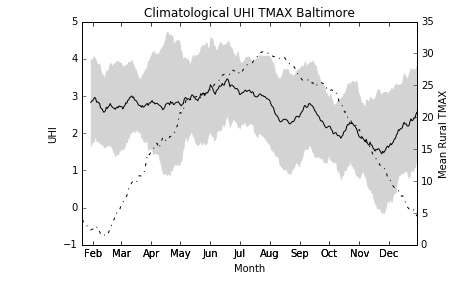

In [131]:
for temp in ['TMIN','TMAX'] : 
        rural = pd.to_numeric(ruraldata[temp]['1985-01-01':].value/10.)
        urban = pd.to_numeric(urbandata[temp]['1985-01-01':].value/10.)

        UHI = urban- rural 

        # plot 
        fig1 = plt.figure()
        ax = fig1.add_subplot(1,1,1)
        ax.plot(time,
                UHI.groupby(UHI.index.day_of_year).mean().rolling(window=30).mean()[0:-1], color = 'k')
        ax.fill_between(time, 
                         UHI.groupby(UHI.index.day_of_year).mean().rolling(window=30).mean()[0:-1]- UHI.groupby(UHI.index.day_of_year).std().rolling(window=21).mean()[0:-1], 
                         UHI.groupby(UHI.index.day_of_year).mean().rolling(window=30).mean()[0:-1] + UHI.groupby(UHI.index.day_of_year).std().rolling(window=21).mean()[0:-1], color = 'lightgray')

        ax.yaxis.tick_left()
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
        plt.xlabel('Month')
        plt.ylabel('UHI')
        plt.title('Climatological UHI %s %s'%(temp,city))
        
        max_UHI =  UHI.groupby(UHI.index.day_of_year).mean().rolling(window=21).mean().max()
        max_UHI_location =  UHI.groupby(UHI.index.day_of_year).mean().rolling(window=21).mean().argmax()
        ax.annotate('max', xy=(max_UHI_location, max_UHI),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )

        ax2 = fig1.add_subplot(111, sharex=ax, frameon=False)
        #if rural.groupby(rural.index.day_of_year).mean().rolling(window=21).mean().shape[0] > 365: 
        line2 = ax2.plot(time, rural.groupby(rural.index.day_of_year).mean().rolling(window=21).mean()[0:365], '-.', color = 'k')
        #else : 
        #    line2 = ax2.plot(time, rural.groupby(rural.index.day_of_year).mean().rolling(window=21).mean(), '-.', color = 'k')

        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")
        plt.ylabel('Mean Rural %s'%temp)

        filename = results_filepath+city.replace(" ", "")[0:5]+temp+'.png'
        #plt.savefig(filename)